This project was done for the "artificial intelligence" course given during the mixte-week of december 2024 at Mines Paris. The full repo is available on [github](https://github.com/AlexiaALLAL/Mixt_december).

# Unsupervised Feature Alignment with Soft DTW Loss

In this exercise we will use a library to get a distance function on time-series and use that as loss. You will get to know dynamic time warping which can be used to measure the distance between sequences. You will also use a certain network architecture called Siamese network which can be used supervised but also unsupervised to map positive and negative examples into a feature space and then minimize the distance of their feature representation. In this notebook you will use both together to train a network unsupervised to create a representation where similar activities are close to each other and finally use a kNN classifier to calculate the performance on a downstream classification task. 

### Exercise Overview

In this exercise, you will:
1. Use a library for **SOFT** Dynamic Time Warping (DTW) to compute time-series similarity. (Soft is very important as normal DTW is not differentiable). Please look into pysdtw (Available with pip or https://github.com/toinsson/pysdtw) which is a pytorch based Cuda-ready version.
2. Implement a custom PyTorch Dataset for generating sequence pairs dynamically.
3. Train a Siamese network using Soft DTW as the loss function.
4. Evaluate the learned representations using a k-Nearest Neighbors (kNN) classifier.
5. Finetune using a single linear layer
6. Visualize and analyze the results.
7. (Bonus) Show the strength between the correlation between the DTW-distance of the input and the feature representation.

### Dataset
We will use the UCI Human Activity Recognition (HAR) dataset, which contains time-series data from smartphone accelerometers and gyroscopes.

**Important**: At the end you should write a report of adequate size, which will probably mean at least half a page. In the report you should describe how you approached the task. You should describe:
- Encountered difficulties (due to the method, e.g. "not enough training samples to converge", not technical like "I could not install a package over pip")
- Steps taken to alleviate difficulties
- General description of what you did, explain how you understood the task and what you did to solve it in general language, no code.
- Potential limitations of your approach, what could be issues, how could this be hard on different data or with slightly different conditions
- If you have an idea how this could be extended in an interesting way, describe it.

# Some explanations

## Dynamic Time Warping
Dynamic Time Warping (DTW) is an algorithm used to measure the similarity between two time series, even if they are out of sync in terms of speed or timing. Unlike traditional methods that align data point by point, DTW allows for non-linear alignment by "warping" the time axis. The idea is to find the optimal match between two sequences by stretching or compressing them along the time axis, minimizing the total distance between corresponding points. DTW does this by computing a cost matrix, where each entry represents the cost of aligning a point from one series with a point from the other. The path with the lowest cumulative cost is the optimal alignment.

As a distance function, DTW is useful for comparing time series that might have different lengths or varying speeds. For example, DTW can be applied to applications such as speech recognition, where two spoken phrases might be of different lengths or spoken at different speeds, but still convey the same meaning. By calculating the DTW distance, we can measure how similar two time series are, regardless of time shifts or distortions. 

Excellent introduction: https://www.youtube.com/watch?v=ERKDHZyZDwA

## Siamese Networks
Siamese Networks are a type of neural network architecture designed for comparing two inputs and measuring their similarity. Instead of directly predicting a single label for an input, Siamese Networks take in two input data points, pass them through identical networks (hence "siamese"), and compare the outputs. The network can be trained by stating if the two inputs are equal or uneqal. If they map into a feature space instead of immediately into an output label space, the distance in the feature space can be used in the loss function which is the task here.

In the context of this unsupervised representation learning, Siamese Networks can be used to learn meaningful features from unlabeled data. A popular technique related to this is *MoCo* (Momentum Contrast), which uses Siamese-like networks for contrastive learning. In MoCo, two different views (augmented versions) of the same data point are passed through two identical networks. One network is updated using the current model, while the other follows a momentum-based update rule. The networks are trained to bring the representations of similar views (positive pairs) closer together, while pushing the representations of dissimilar views (negative pairs) apart. This approach allows the model to learn useful representations for later fine-tuning on a classification task without needing explicit labels, relying instead on the assumption that augmented views of the same instance should be similar in the learned feature space.

In this exercise the Siamese network should be used to learn to structure the feature space, guided by the similarity calculation of the DTW. After it should be evaluated how well that method performs for classification. The comment about MoCo is only for information about this close topic, it is not necessary to use it at all.

## Part 1: Data Preparation

Load the UCI HAR dataset and implement a custom `Dataset` class to generate pairs dynamically.

In [21]:
# Import necessary libraries
from torch.utils.data import Dataset, DataLoader
import torch
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import time

In [22]:
import urllib.request

def unzip(filename, dest_path = None):
    # unzips a zip file in the folder of the notebook to the notebook
    with ZipFile(filename, 'r') as zObject: 
        # Extracting all the members of the zip  
        # into a specific location. a
        if dest_path is None:
            zObject.extractall(path=os.getcwd())
        else:
            zObject.extractall(path=dest_path)

import os
def download(url, filename):
    # download with check if file exists already
    if os.path.isfile(filename):
        return
    urllib.request.urlretrieve(url,filename)

from zipfile import ZipFile

# Un-comment lines below only if executing on Google-COLAB
# ![[ -f UCI_HAR.zip ]] || wget --no-check-certificate https://people.minesparis.psl.eu/fabien.moutarde/ES_MachineLearning/Practical_sequentialData/UCI_HAR.zip
# ![[ -f "UCI_HAR" ]] || unzip UCI_HAR.zip

download('https://people.minesparis.psl.eu/fabien.moutarde/ES_MachineLearning/Practical_sequentialData/UCI_HAR.zip','UCI_HAR.zip')

unzip('UCI_HAR.zip')

In [23]:
# Import Necessary packages
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import sklearn as sk
import sys
print('Your python version: {}'.format(sys.version_info.major))



#Path to the dataset folder
filepath='./UCI_HAR/'

groups=['train','test']

for group in groups:
    prefix=filepath+group+'/InertialSignals/'
    
    
    filenames = list()
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']

    loaded = []
    for name in filenames:
        file=open(prefix+name,'r')
        data = []
        for x in file:
            data.append([float(ts) for ts in x.split()])
        data = np.array(data)
        #Concatenation of all data concerning the two 3D raw features (body acceleration and angular velocity)
        loaded.append(data)

    #Name of the last 3D raw feature
    filenames_rest = ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']

    #First add the two previous 3D raw features
    loaded_all = []
    loaded_all += loaded

    #Then add the last 3D raw feature
    for name in filenames_rest:
        file=open(prefix+name,'r')
        data = []
        for x in file:
            data.append([float(ts) for ts in x.split()])
        data = np.array(data)
        #Concatenation of all data concerning all 3D raw features (body acceleration, angular velocity and total acceleration)
        loaded_all.append(data)

    # Stack group so that features are the 3rd dimension --> (samples, time steps, features)
    loaded = np.dstack(loaded)
    loaded_all = np.dstack(loaded_all)

    if group == 'train':
        #Training set for two 3D raw features
        tx_train = loaded
        #Training set for all 3D raw features
        tx_train_all = loaded_all
    if group =='test':
        #Testing set for two 3D raw features
        tx_test = loaded
        #Testing set for all 3D raw features
        tx_test_all = loaded_all

nbTimeseries = tx_train_all[0].shape[1]
lengthTimeseries = tx_train_all[0].shape[0]
print("Shape of examples:",tx_train_all[0].shape," (i.e. ",nbTimeseries," timeseries of length=",lengthTimeseries,")")

print("Training set shape:",tx_train_all.shape)
print("Test set shape:",tx_test_all.shape)

# Load labels
y_train = []
y_test = []
y_train_file = open(filepath+'train/y_train.txt', 'r')
y_test_file = open(filepath+'test/y_test.txt', 'r')
for y in y_train_file:
    y_train.append(int(y.rstrip('\n')))
for y in y_test_file:
    y_test.append(int(y.rstrip('\n')))
target_train = np.array(y_train) - 1
target_test = np.array(y_test) - 1

# Mapping table for classes
labels = {1:'WALKING', 2:'WALKING UPSTAIRS', 3:'WALKING DOWNSTAIRS',
          4:'SITTING', 5:'STANDING', 6:'LAYING'}

nbClasses = len(labels)
print("Number of classes =", nbClasses)
print("Activity classes (target values)",labels)

# Shuffle (because data is initially somewhat organized by class)
tx_train_all, target_train = sk.utils.shuffle(tx_train_all, target_train, random_state=0)
tx_test_all, target_test = sk.utils.shuffle(tx_test_all, target_test, random_state=0)

Your python version: 3
Shape of examples: (128, 9)  (i.e.  9  timeseries of length= 128 )
Training set shape: (7352, 128, 9)
Test set shape: (2947, 128, 9)
Number of classes = 6
Activity classes (target values) {1: 'WALKING', 2: 'WALKING UPSTAIRS', 3: 'WALKING DOWNSTAIRS', 4: 'SITTING', 5: 'STANDING', 6: 'LAYING'}


In [24]:
# Define a custom Dataset for Siamese Network
class SiameseDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Define the logic for selecting pairs of sequences
        pair_label = round(random.randint(0, 1))

        if pair_label:
            # Positive pair (same class), label = 1
            idx2 = random.randint(0, len(self.data) - 1)
            while self.labels[idx2] != self.labels[idx]:
                idx2 = random.randint(0, len(self.data) - 1)

        else:
            # Negative pair (different class), label = 0
            idx2 = random.randint(0, len(self.data) - 1)
            while self.labels[idx2] == self.labels[idx]:
                idx2 = random.randint(0, len(self.data) - 1)

        seq1 = self.data[idx][:, :6]
        seq2 = self.data[idx2][:, :6]
        seq1 = torch.tensor(seq1, dtype=torch.float32, requires_grad=True)
        seq2 = torch.tensor(seq2, dtype=torch.float32, requires_grad=True)
        label = torch.tensor([pair_label], dtype=torch.float32, requires_grad=True)
        return seq1, seq2, pair_label

# Create train and test datasets using the custom Dataset class
train_dataset_siamese = SiameseDataset(tx_train_all, target_train)
test_dataset_siamese = SiameseDataset(tx_test_all, target_test)

In [25]:
# let's create another dataset class for simple feedforward network
class Dataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq = self.data[idx]
        label = self.labels[idx]
        return torch.tensor(seq, dtype=torch.float32, requires_grad=True), torch.tensor(label, dtype=torch.float32)

train_dataset_simple = Dataset(tx_train_all[:,:,0:6], target_train)
test_dataset_simple = Dataset(tx_test_all[:,:,0:6], target_test)

In [26]:
tx_train_all.shape

(7352, 128, 9)

In [27]:
target_train.shape

(7352,)

7352 times series of 128 timesteps of 9 features.

## Part 2: Using a DTW Library

Use a library to compute the Dynamic Time Warping (DTW) distance between sequences. Implement a differentiable Soft DTW function to calculate this distance.

In [28]:
# Install and use a DTW library like pysdtw
import pysdtw

def dtw_distance(seq1, seq2):
    # Compute the DTW distance between two sequences
    # optionally choose a pairwise distance function
    # seq1 of shape (128, 9), seq2 of shape (128, 9)
    fun = pysdtw.distance.pairwise_l2_squared

    # create the SoftDTW distance function
    sdtw = pysdtw.SoftDTW(gamma=0.001, dist_func=fun, use_cuda=False)

    # soft-DTW discrepancy, approaches DTW as gamma -> 0
    # compare each acceleration and gyro data
    # accx = sdtw(seq1[:, 0], seq2[:, 0])
    # accy = sdtw(seq1[:, 1], seq2[:, 1])
    # accz = sdtw(seq1[:, 2], seq2[:, 2])
    # gyrox = sdtw(seq1[:, 3], seq2[:, 3])
    # gyroy = sdtw(seq1[:, 4], seq2[:, 4])
    # gyroz = sdtw(seq1[:, 5], seq2[:, 5])
    # res = (accx + accy + accz) / 3
    res = sdtw(seq1, seq2)
    loss = res.mean()
    return loss

# Test the DTW function with example sequences
d_0 = []
d_1 = []
n = 50
for i in range(n):
    seq1, seq2, label = train_dataset_siamese[0]
    # print(seq1.shape)
    seq1 = seq1.unsqueeze(0)
    seq2 = seq2.unsqueeze(0)
    distance = dtw_distance(seq1, seq2)
    if label == 0:
        d_0.append(distance.item())
    else:
        d_1.append(distance.item())
    print(f"DTW distance: {distance}, Label: {label}")


print(f"\n\nMean DTW distance for label 0: {np.mean(d_0):.3f}")
print(f"Mean DTW distance for label 1: {np.mean(d_1):.3f}")

DTW distance: -0.07301003485918045, Label: 1
DTW distance: 0.17843195796012878, Label: 1
DTW distance: -0.00493689114227891, Label: 1
DTW distance: -0.06125800311565399, Label: 0
DTW distance: 151.23094177246094, Label: 0
DTW distance: 5.221961498260498, Label: 1
DTW distance: 0.198807954788208, Label: 1
DTW distance: 0.05567480996251106, Label: 1
DTW distance: 141.82151794433594, Label: 0
DTW distance: 1.3047990798950195, Label: 1
DTW distance: -0.07423827052116394, Label: 0
DTW distance: -0.03795577585697174, Label: 1
DTW distance: 0.9046757221221924, Label: 0
DTW distance: -0.019858554005622864, Label: 0
DTW distance: -0.06864536553621292, Label: 0
DTW distance: -0.07627661526203156, Label: 1
DTW distance: 0.14555899798870087, Label: 1
DTW distance: -0.10454677790403366, Label: 0
DTW distance: 245.14146423339844, Label: 0
DTW distance: 1.1464155912399292, Label: 0
DTW distance: 0.08319590985774994, Label: 1
DTW distance: 86.14013671875, Label: 0
DTW distance: -0.07615729421377182, L

## Part 3: Train a Siamese Network

Define and train a Siamese network in PyTorch using the Soft DTW loss function. Implement the network structure and training logic.

In [29]:
# Define a Siamese Network class
class SiameseNetwork(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SiameseNetwork, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.train_time = None

        # Initialize the network layers
        # input_size=(128 x 6), we want to reduce it to hidden_size=128
        self.first_layers = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.ReLU()
        ) 
        # output (128x128) at this point
        self.last_layers = torch.nn.Sequential(
            torch.nn.Linear(hidden_size * 128, hidden_size),
            torch.nn.ReLU()
        )   

    def forward_one(self, x):
        # Forward pass logic for one branch
        x = self.first_layers(x)
        x = x.view(-1, self.hidden_size * 128)
        x = self.last_layers(x)
        return x

    def forward(self, input1, input2):
        # Logic for processing both branches
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2

# Train the network with the defined loss function (dtw_distance) and optimizer
def train_network(model, train_loader, criterion, use_dtw, optimizer, num_epochs=10):
    start = time.time()
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for i, (seq1, seq2, label) in enumerate(train_loader):
            optimizer.zero_grad()
            out1, out2 = model(seq1, seq2)
            if use_dtw:
                loss = criterion(seq1, seq2, out1, out2)
            else:
                loss = criterion(out1, out2, label.float())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss}")
    end = time.time()
    print("Training time:", end - start)
    model.train_time = end - start
    return model


class ContrastiveLoss(torch.nn.Module):
    """
    Classic contrastive loss function, without DTW distance    
    """
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = torch.nn.functional.pairwise_distance(output1, output2)
        pos = (1-label) * torch.pow(euclidean_distance, 2) # if label = 0, we want the distance to be small
        neg = (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2) # if label = 1, we want the distance to be large
        loss_contrastive = torch.mean( pos + neg )
        return loss_contrastive

class ContrastiveLossDtw(torch.nn.Module):
    """
    Adapted contrastive loss function using DTW distance    
    """
    def __init__(self, margin=2.0):
        super(ContrastiveLossDtw, self).__init__()
        self.margin = margin    

    def forward(self, input1, input2, output1, output2):
        # adapt the contrastive loss function to the DTW distance
        # use the euclidean distance to compare the two outputs
        # use the dtw_distance on the inputs to get the ground truth distance
        euclidean_distance = torch.nn.functional.pairwise_distance(output1, output2)
        dtw = dtw_distance(input1, input2)
        loss = torch.pow(euclidean_distance - dtw, 2)
        return torch.mean(loss)

# Create a DataLoader
train_loader_siamese = DataLoader(train_dataset_siamese, batch_size=64, shuffle=True)
test_loader_siamese = DataLoader(test_dataset_siamese, batch_size=64, shuffle=False)

In [18]:
model_classic_contrastive= SiameseNetwork(input_size=train_dataset_siamese[0][0].shape[1], hidden_size = 128)
optimizer = torch.optim.Adam(model_classic_contrastive.parameters(), lr=0.001)
model_classic_contrastive = train_network(
    model= model_classic_contrastive,
    train_loader= train_loader_siamese, 
    criterion = ContrastiveLoss(margin=1.5), 
    use_dtw=False,
    optimizer=optimizer, num_epochs=50
    )

Epoch 1, Loss: 87.6369857788086
Epoch 2, Loss: 77.90319812297821
Epoch 3, Loss: 75.86075794696808
Epoch 4, Loss: 73.96627676486969
Epoch 5, Loss: 72.92740875482559
Epoch 6, Loss: 72.37480121850967
Epoch 7, Loss: 70.34533727169037
Epoch 8, Loss: 69.91648012399673
Epoch 9, Loss: 69.3684366941452
Epoch 10, Loss: 68.55814355611801
Epoch 11, Loss: 68.61245599389076
Epoch 12, Loss: 68.21440136432648
Epoch 13, Loss: 68.799007833004
Epoch 14, Loss: 68.71075934171677
Epoch 15, Loss: 68.35948610305786
Epoch 16, Loss: 67.78953391313553
Epoch 17, Loss: 68.68317425251007
Epoch 18, Loss: 69.01555573940277
Epoch 19, Loss: 68.11075001955032
Epoch 20, Loss: 68.27711963653564
Epoch 21, Loss: 67.8151812851429
Epoch 22, Loss: 67.85799688100815
Epoch 23, Loss: 67.82797765731812
Epoch 24, Loss: 67.24106460809708
Epoch 25, Loss: 66.72812008857727
Epoch 26, Loss: 67.6328746676445
Epoch 27, Loss: 67.68596929311752
Epoch 28, Loss: 67.2288880944252
Epoch 29, Loss: 67.76292526721954
Epoch 30, Loss: 67.20227259397

In [31]:
model_dtw = SiameseNetwork(input_size=train_dataset_siamese[0][0].shape[1], hidden_size = 128)
optimizer = torch.optim.Adam(model_dtw.parameters(), lr=0.001)
model_dtw = train_network(
    model= model_dtw,
    train_loader= train_loader_siamese,
    criterion = ContrastiveLossDtw(margin=1.5), 
    use_dtw=True,
    optimizer=optimizer, num_epochs=50)

Epoch 1, Loss: 329437.1838378906
Epoch 2, Loss: 167480.65985107422
Epoch 3, Loss: 99121.88165283203
Epoch 4, Loss: 74622.12747192383
Epoch 5, Loss: 56802.60763549805
Epoch 6, Loss: 48338.405502319336
Epoch 7, Loss: 47562.24005126953
Epoch 8, Loss: 42596.2737121582
Epoch 9, Loss: 41412.16069030762
Epoch 10, Loss: 40780.65026855469
Epoch 11, Loss: 35202.890617370605
Epoch 12, Loss: 32786.600830078125
Epoch 13, Loss: 34418.7699508667
Epoch 14, Loss: 36324.98403930664
Epoch 15, Loss: 34844.41384887695
Epoch 16, Loss: 32381.19113922119
Epoch 17, Loss: 31809.643432617188
Epoch 18, Loss: 25933.841842651367
Epoch 19, Loss: 30290.706424713135
Epoch 20, Loss: 35434.9391746521
Epoch 21, Loss: 31325.332584381104
Epoch 22, Loss: 31840.58383178711
Epoch 23, Loss: 28972.741729736328
Epoch 24, Loss: 25674.003231048584
Epoch 25, Loss: 27747.854026794434
Epoch 26, Loss: 27100.02758026123
Epoch 27, Loss: 25417.268173217773
Epoch 28, Loss: 32300.91659927368
Epoch 29, Loss: 29095.612648010254
Epoch 30, Los

## Part 4: Evaluate Representations with kNN

Use the trained network to extract embeddings and evaluate their quality using a kNN classifier.

In [20]:
tx_train_all.shape

(7352, 128, 9)

In [21]:
train_features = model_classic_contrastive.forward_one(torch.tensor(tx_train_all[:,:,0:6], dtype=torch.float32))
test_features = model_classic_contrastive.forward_one(torch.tensor(tx_test_all[:,:,0:6], dtype=torch.float32))
train_features.shape

torch.Size([7352, 128])

### Network with classic contrastive loss

Accuracy: 0.3820834747200543
Confusion Matrix:
[[296  58  41  39  17  45]
 [175 150  80  20  14  32]
 [152  89  82  35  16  46]
 [ 21  14  15 241  72 128]
 [ 38  31  25 201 103 134]
 [ 31  10   9 169  64 254]]


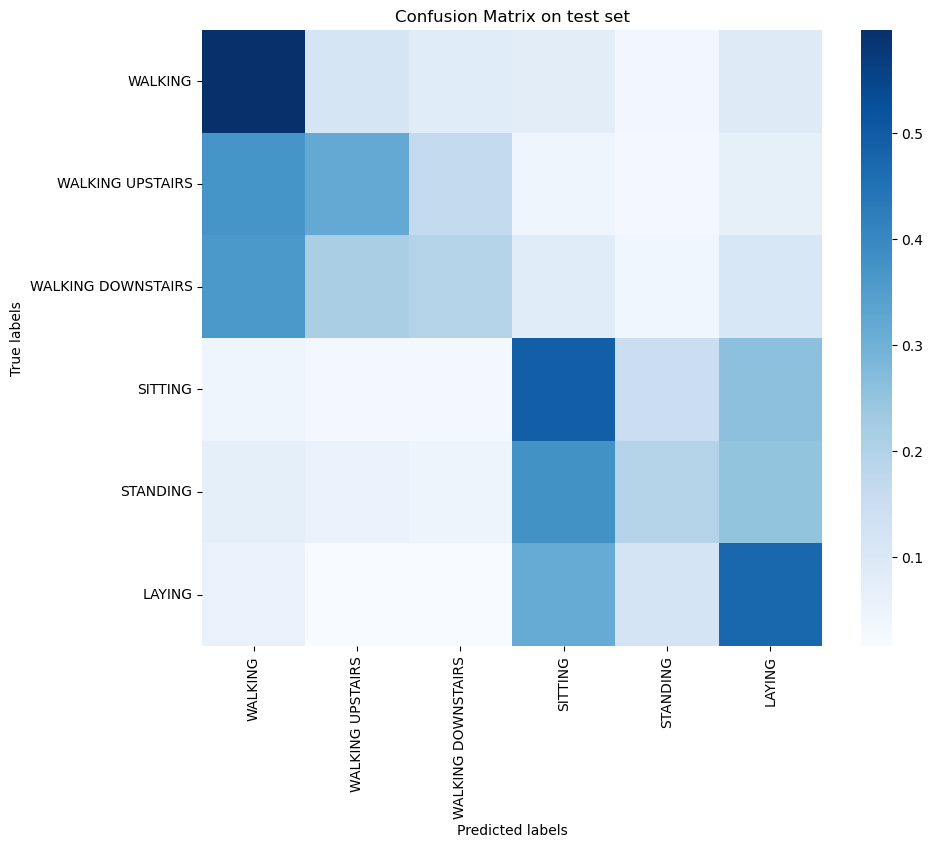

In [ ]:
knn = KNeighborsClassifier(
    n_neighbors=3
)
# evaluate on the test set
# for a point of the test set, retrieve the nearest neighbors in the train set
# and assign the label of the majority of the neighbors
knn.fit(train_features.detach().numpy(), target_train)
y_pred = knn.predict(test_features.detach().numpy())
accuracy = accuracy_score(target_test, y_pred)
conf_matrix = confusion_matrix(target_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(target_test, y_pred, normalize='true')
sns.heatmap(
    conf_matrix, fmt='g', cmap='Blues',
    xticklabels=labels.values(), yticklabels=labels.values())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix on test set')
plt.show()

### Network with DTW loss

Accuracy: 0.3820834747200543
Confusion Matrix:
[[296  58  41  39  17  45]
 [175 150  80  20  14  32]
 [152  89  82  35  16  46]
 [ 21  14  15 241  72 128]
 [ 38  31  25 201 103 134]
 [ 31  10   9 169  64 254]]


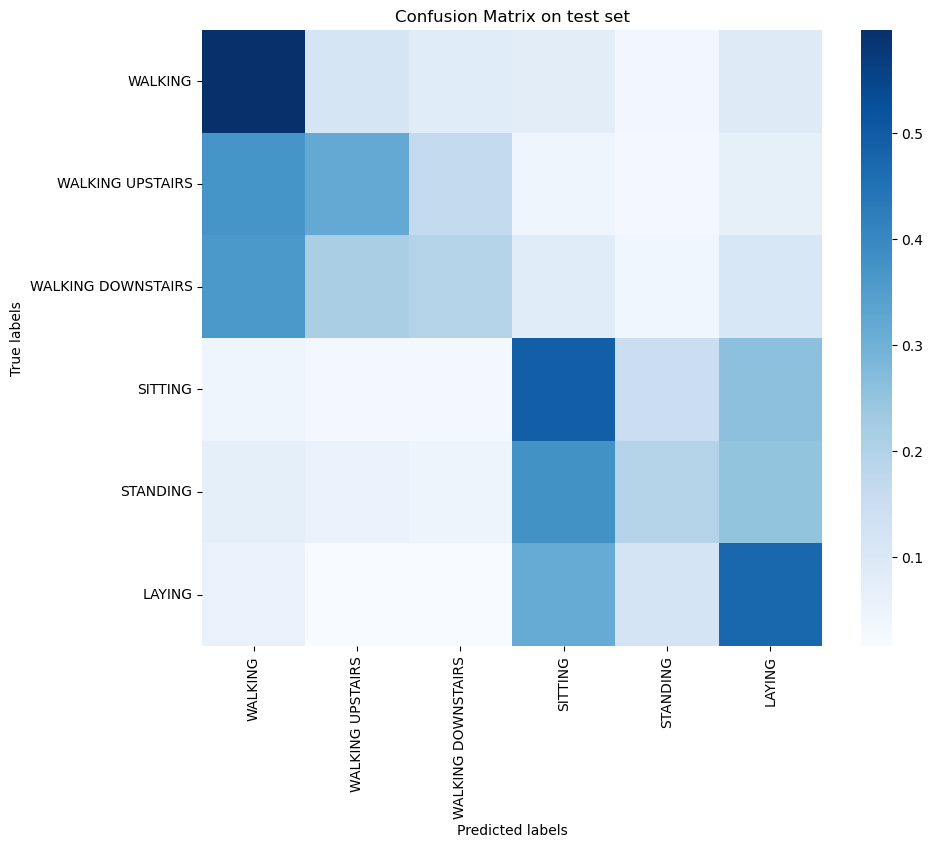

In [ ]:
knn = KNeighborsClassifier(
    n_neighbors=3
)
# evaluate on the test set
# for a point of the test set, retrieve the nearest neighbors in the train set
# and assign the label of the majority of the neighbors
knn.fit(train_features.detach().numpy(), target_train)
y_pred = knn.predict(test_features.detach().numpy())
accuracy = accuracy_score(target_test, y_pred)
conf_matrix = confusion_matrix(target_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(target_test, y_pred, normalize='true')
sns.heatmap(
    conf_matrix, fmt='g', cmap='Blues',
    xticklabels=labels.values(), yticklabels=labels.values())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix on test set')
plt.show()

The results are pretty good. We can see that some classes are very well separated, while others are more mixed. For example, standing is often mistaken for sitting, and walking upstairs is often mistaken for walking. This is expected, as these activities are similar in nature and can be hard to distinguish based on accelerometer data alone.

## Part 5: Fine-Tuning with a Linear Layer

Freeze the Siamese network and add a linear layer on top. Fine-tune the linear layer and re-evaluate the model.

### Network with classic contrastive loss and fine-tuning

In [24]:
# Freeze the Siamese network
for param in model_classic_contrastive.parameters():
    param.requires_grad = False

# Add and train a few linear layers for fine-tuning
fc = torch.nn.Sequential(
    torch.nn.Linear(128, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 6),
    torch.nn.Softmax(dim=1)
)

def fine_tune(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        for i, (seq, label) in enumerate(train_loader):
            optimizer.zero_grad()
            out = model.forward_one(seq)
            out = fc(out)
            loss = criterion(out, label.long())
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    return model

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fc.parameters(), lr=0.001)


train_loader_simple = DataLoader(train_dataset_simple, batch_size=64, shuffle=True)
test_loader_simple = DataLoader(test_dataset_simple, batch_size=64, shuffle=False)

model_classic_contrastive = fine_tune(model_classic_contrastive, train_loader_simple, criterion, optimizer, num_epochs=20)

Epoch 1, Loss: 1.790988564491272
Epoch 2, Loss: 1.7869160175323486
Epoch 3, Loss: 1.7892271280288696
Epoch 4, Loss: 1.7380770444869995
Epoch 5, Loss: 1.755392074584961
Epoch 6, Loss: 1.7379913330078125
Epoch 7, Loss: 1.722912073135376
Epoch 8, Loss: 1.714503288269043
Epoch 9, Loss: 1.7399269342422485
Epoch 10, Loss: 1.7391674518585205
Epoch 11, Loss: 1.7366846799850464
Epoch 12, Loss: 1.705023169517517
Epoch 13, Loss: 1.6985985040664673
Epoch 14, Loss: 1.7265273332595825
Epoch 15, Loss: 1.6947968006134033
Epoch 16, Loss: 1.6831597089767456
Epoch 17, Loss: 1.7133973836898804
Epoch 18, Loss: 1.6641937494277954
Epoch 19, Loss: 1.676822543144226
Epoch 20, Loss: 1.687822699546814


Accuracy: 0.31964709874448594
Confusion Matrix:
[[289  67   3  15  67  55]
 [247  93   5  10  66  50]
 [245  59   3   7  60  46]
 [ 32   9   1 108 146 195]
 [ 64  16   2  84 183 183]
 [ 34   4   0 116 117 266]]


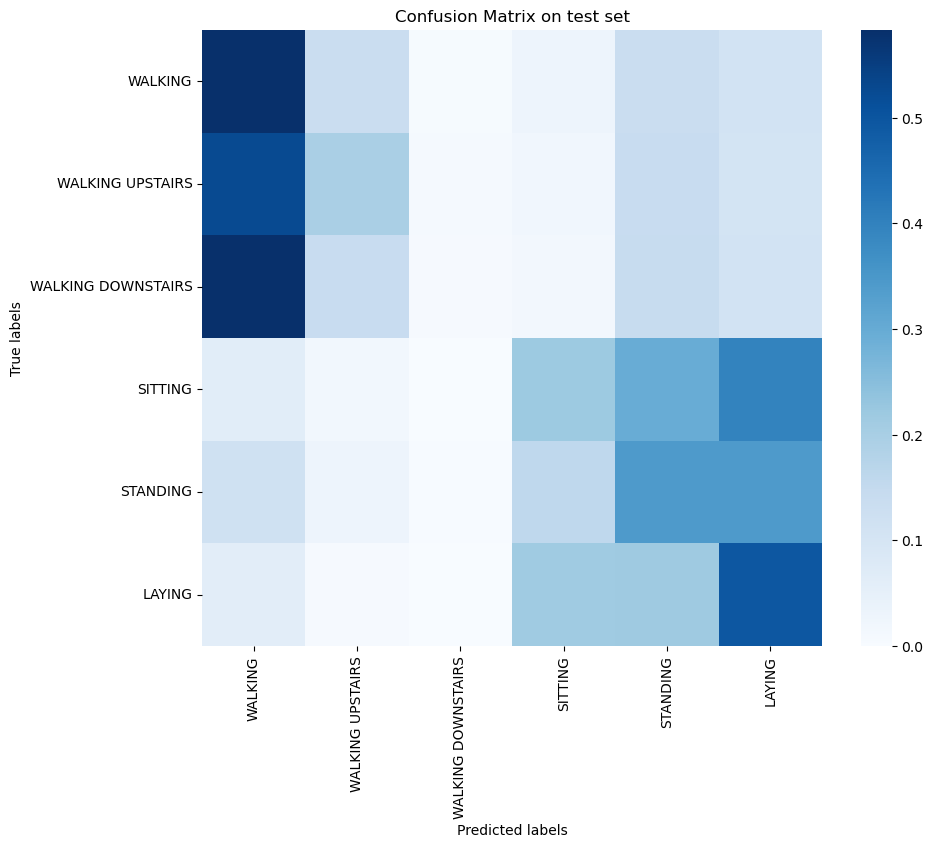

In [25]:
# Evaluate the fine-tuned model
def evaluate(model, test_loader):
    model.eval()
    y_pred = []
    y_true = []
    for i, (seq, label) in enumerate(test_loader):
        out = model.forward_one(seq)
        out = fc(out)
        pred = torch.argmax(out, dim=1)
        y_pred.extend(pred.detach().numpy())
        y_true.extend(label.detach().numpy())
    return y_true, y_pred

y_true, y_pred = evaluate(model_classic_contrastive, test_loader_simple)
accuracy = accuracy_score(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_true, y_pred, normalize='true')
sns.heatmap(
    conf_matrix, fmt='g', cmap='Blues',
    xticklabels=labels.values(), yticklabels=labels.values())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix on test set')
plt.show()

### Network with DTW loss and fine-tuning

In [32]:
# Freeze the Siamese network
for param in model_dtw.parameters():
    param.requires_grad = False

# Add and train a few linear layers for fine-tuning
fc = torch.nn.Sequential(
    torch.nn.Linear(128, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 6),
    torch.nn.Softmax(dim=1)
)

def fine_tune(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        for i, (seq, label) in enumerate(train_loader):
            optimizer.zero_grad()
            out = model.forward_one(seq)
            out = fc(out)
            loss = criterion(out, label.long())
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    return model

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fc.parameters(), lr=0.001)

train_loader_simple = DataLoader(train_dataset_simple, batch_size=64, shuffle=True)
test_loader_simple = DataLoader(test_dataset_simple, batch_size=64, shuffle=False)

model_dtw = fine_tune(model_dtw, train_loader_simple, criterion, optimizer, num_epochs=50)

Epoch 1, Loss: 1.5990524291992188
Epoch 2, Loss: 1.5443875789642334
Epoch 3, Loss: 1.4990102052688599
Epoch 4, Loss: 1.4307280778884888
Epoch 5, Loss: 1.5261802673339844
Epoch 6, Loss: 1.4576135873794556
Epoch 7, Loss: 1.4560614824295044
Epoch 8, Loss: 1.424600601196289
Epoch 9, Loss: 1.4239882230758667
Epoch 10, Loss: 1.343140959739685
Epoch 11, Loss: 1.3491548299789429
Epoch 12, Loss: 1.3193120956420898
Epoch 13, Loss: 1.3320075273513794
Epoch 14, Loss: 1.3626924753189087
Epoch 15, Loss: 1.335921049118042
Epoch 16, Loss: 1.2926501035690308
Epoch 17, Loss: 1.3869787454605103
Epoch 18, Loss: 1.3686389923095703
Epoch 19, Loss: 1.3381859064102173
Epoch 20, Loss: 1.2973397970199585
Epoch 21, Loss: 1.2826173305511475
Epoch 22, Loss: 1.3357956409454346
Epoch 23, Loss: 1.2854386568069458
Epoch 24, Loss: 1.291741967201233
Epoch 25, Loss: 1.3705519437789917
Epoch 26, Loss: 1.359466791152954
Epoch 27, Loss: 1.2641021013259888
Epoch 28, Loss: 1.1761294603347778
Epoch 29, Loss: 1.2270429134368896

Accuracy: 0.5595520868680014
Confusion Matrix:
[[350  46  93   1   5   1]
 [ 84 281  94   3   7   2]
 [ 64  84 258   2  11   1]
 [  5   6   2 189 185 104]
 [ 23  13  21 102 281  92]
 [ 11   3   2  88 143 290]]


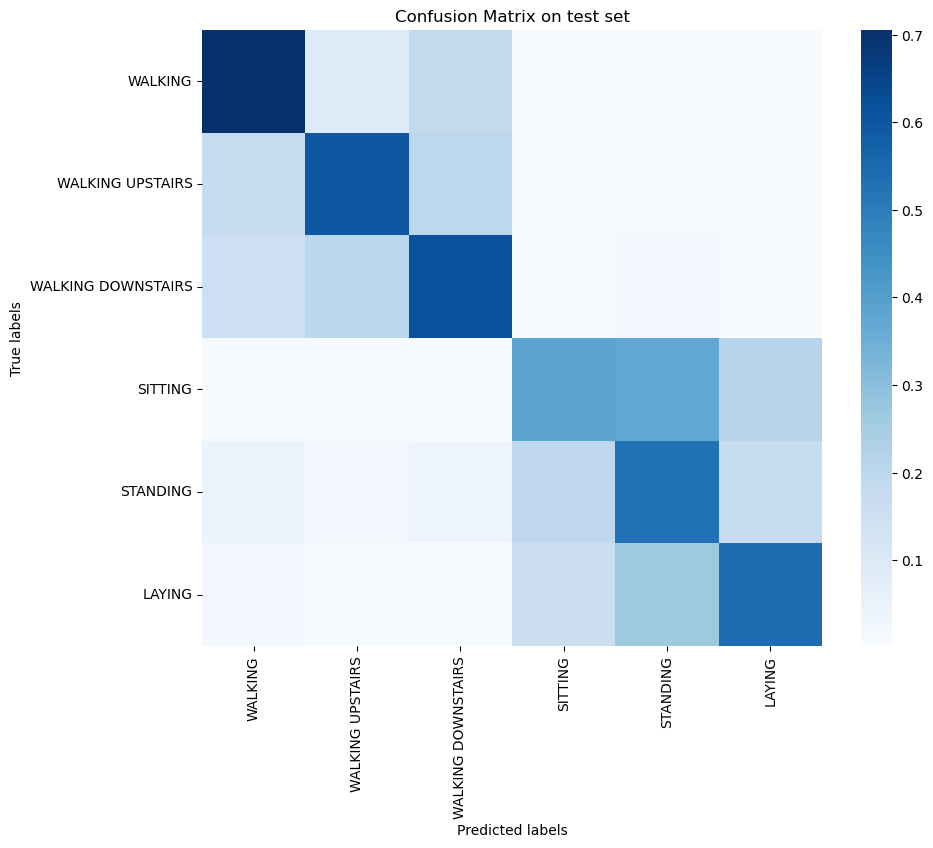

In [33]:
# Evaluate the fine-tuned model
def evaluate(model, test_loader):
    model.eval()
    y_pred = []
    y_true = []
    for i, (seq, label) in enumerate(test_loader):
        out = model.forward_one(seq)
        out = fc(out)
        pred = torch.argmax(out, dim=1)
        y_pred.extend(pred.detach().numpy())
        y_true.extend(label.detach().numpy())
    return y_true, y_pred

y_true, y_pred = evaluate(model_dtw, test_loader_simple)
accuracy = accuracy_score(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_true, y_pred, normalize='true')
sns.heatmap(
    conf_matrix, fmt='g', cmap='Blues',
    xticklabels=labels.values(), yticklabels=labels.values())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix on test set')
plt.show()

## Part 6: Compare Siamese Network with a normal network

This is not part of the exercise but we compared the performance of a normal network with the same architecture and the same amount of parameters, to see if the Siamese network really helps to learn a better representation.

In [ ]:
# Define a simple model for classification, with the same hyperparameters as the Siamese network

class SimpleModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # input_size=(128 x 6), we want to reduce it to hidden_size=128
        self.first_layers = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.ReLU()
        ) 

        # output (128x128) at this point
        self.last_layers = torch.nn.Sequential(
            torch.nn.Linear(hidden_size * 128, hidden_size),
            torch.nn.ReLU()
        )
        # output (128) at this point
        # Add a fully connected layer for classification
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 6),
            torch.nn.Softmax(dim=1)
        ) 

    def forward(self, x):
        # Forward pass logic for one branch
        x = self.first_layers(x)
        x = x.view(-1, self.hidden_size * 128)
        x = self.last_layers(x)
        x = self.fc(x)
        return x

def train_simple_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        for i, (seq, label) in enumerate(train_loader):
            optimizer.zero_grad()
            out = model(seq)
            loss = criterion(out, label.long())
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    return model

input_size = train_dataset_simple[0][0].shape[1]
hidden_size = 128 # features space dimension
simple_model = SimpleModel(input_size, hidden_size)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(simple_model.parameters(), lr=0.001)

train_loader_simple = DataLoader(train_dataset_simple, batch_size=64, shuffle=True)
test_loader_simple = DataLoader(test_dataset_simple, batch_size=64, shuffle=False)

simple_model = train_simple_model(simple_model, train_loader_simple, criterion, optimizer, num_epochs=20)

Epoch 1, Loss: 1.563024878501892
Epoch 2, Loss: 1.3929647207260132


Accuracy: 0.5744825246012895
Confusion Matrix:
[[340  95  23   1   0  37]
 [  7 453  10   0   0   1]
 [ 12  62 346   0   0   0]
 [  2   1   0  17   0 471]
 [  2   1   0   2   0 527]
 [  0   0   0   0   0 537]]


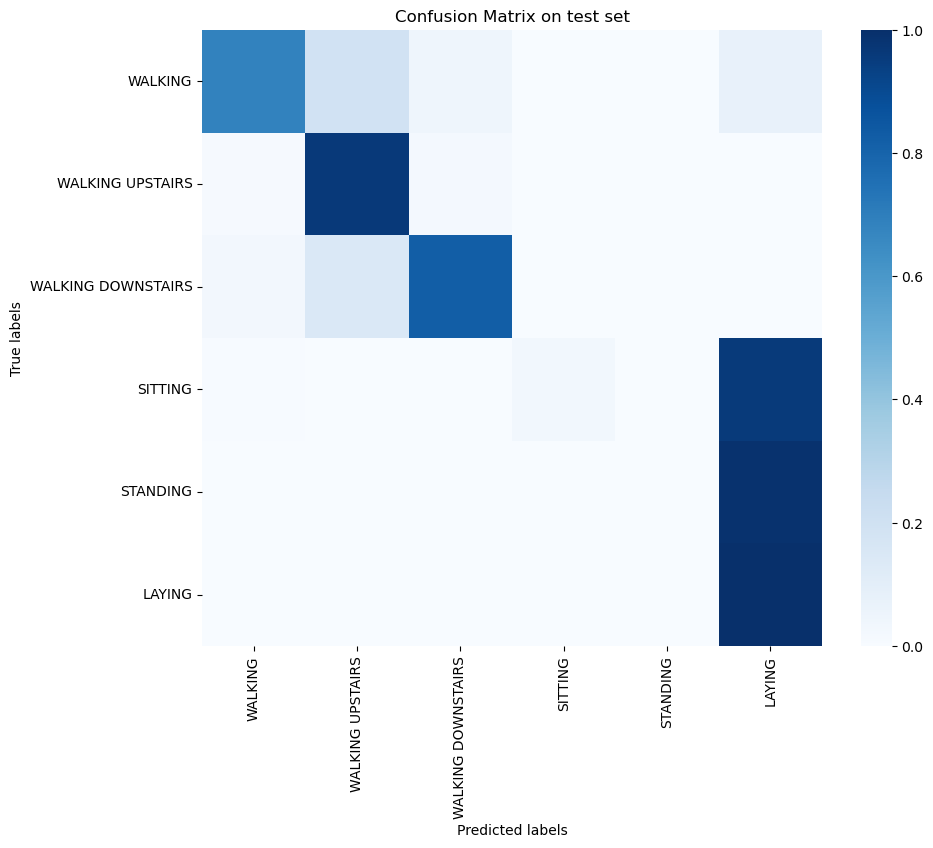

In [17]:
# Evaluate the simple model
def evaluate(model, test_loader):
    model.eval()
    y_pred = []
    y_true = []
    for i, (seq, label) in enumerate(test_loader):
        out = model(seq)
        pred = torch.argmax(out, dim=1)
        y_pred.extend(pred.detach().numpy())
        y_true.extend(label.detach().numpy())
    return y_true, y_pred

y_true, y_pred = evaluate(simple_model, test_loader_simple)
accuracy = accuracy_score(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_true, y_pred, normalize='true')
sns.heatmap(
    conf_matrix, fmt='g', cmap='Blues',
    xticklabels=labels.values(), yticklabels=labels.values())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix on test set')
plt.show()

We can see that the simple network also perform well. This is a bit decieving...
We tested two different losses to train the Siamese network, the classic contrastive loss and the DTW loss. The DTW loss performed better, as we can see in the results above.